In [1]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import classification_report, confusion_matrix, precision_score
import seaborn as sns
import pandas as pd
import time
import collections

In [2]:
# --- Cấu hình ---
data_dir = "."
input_size = 224
batch_size = 32
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# --- Transform ---
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ])
}

In [4]:
# --- Dataset & DataLoader ---
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2)
    for x in ['train', 'val']
}




class_names = image_datasets['train'].classes
num_classes = len(class_names)

print("Class names:", class_names)
print("Number of classes:", num_classes)

Class names: ['other_activities', 'safe_driving', 'talking_phone', 'texting_phone', 'turning']
Number of classes: 5


In [5]:
# --- Mô hình EfficientNet-B0 ---
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_ftrs, num_classes)
)
model = model.to(device)

d:\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# --- Loss và optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# --- Huấn luyện ---
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total

        print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())


Epoch 1/10
------------------------------
Train Loss: 0.4596 | Accuracy: 0.8297
Val Loss: 0.2550 | Accuracy: 0.9103

Epoch 2/10
------------------------------
Train Loss: 0.2499 | Accuracy: 0.9032
Val Loss: 0.1911 | Accuracy: 0.9269

Epoch 3/10
------------------------------
Train Loss: 0.1803 | Accuracy: 0.9306
Val Loss: 0.2402 | Accuracy: 0.9145

Epoch 4/10
------------------------------
Train Loss: 0.1592 | Accuracy: 0.9399
Val Loss: 0.1516 | Accuracy: 0.9421

Epoch 5/10
------------------------------
Train Loss: 0.1499 | Accuracy: 0.9423
Val Loss: 0.1851 | Accuracy: 0.9228

Epoch 6/10
------------------------------
Train Loss: 0.1200 | Accuracy: 0.9534
Val Loss: 0.2304 | Accuracy: 0.9228

Epoch 7/10
------------------------------
Train Loss: 0.1138 | Accuracy: 0.9596
Val Loss: 0.1708 | Accuracy: 0.9448

Epoch 8/10
------------------------------
Train Loss: 0.1021 | Accuracy: 0.9624
Val Loss: 0.1776 | Accuracy: 0.9338

Epoch 9/10
------------------------------
Train Loss: 0.0884 | 

In [8]:
# --- Lưu mô hình ---
torch.save(model.state_dict(), "EfficientNet_B0.pth")
print("\nMô hình đã lưu vào EfficientNet_B0.pth")



Mô hình đã lưu vào EfficientNet_B0.pth


In [9]:
# --- Dataset test không có nhãn ---
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) 
                            for fname in os.listdir(root_dir) 
                            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

test_dataset = TestDataset(os.path.join(data_dir, 'test'), transform=data_transforms['test'])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# --- Hàm load mô hình ---
def load_model(path, num_classes):
    model = models.efficientnet_b0(pretrained=False)
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(num_ftrs, num_classes)
    )
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    return model

def predict_image_tensor(batch_tensor, model, class_names):
    batch_tensor = batch_tensor.to(device)
    with torch.no_grad():
        outputs = model(batch_tensor)
        _, preds = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)
        return preds.cpu(), probs.cpu().numpy()

In [11]:
# --- Dự đoán toàn bộ ảnh test ---
model_loaded = load_model("EfficientNet_B0.pt", num_classes)

d:\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24904\2886811709.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_g

In [12]:
print("\nDự đoán trên tập test:")
for imgs, paths in test_loader:
    preds_batch, probs_batch = predict_image_tensor(imgs, model_loaded, class_names)
    for i in range(len(paths)):
        pred_label = class_names[preds_batch] if isinstance(preds_batch, int) else class_names[preds_batch[i]]
        confidence = probs_batch[i][preds_batch[i]] if len(paths) > 1 else probs_batch[preds_batch]
        print(f"Ảnh: {os.path.basename(paths[i])} -> Dự đoán: {pred_label} ({confidence*100:.2f}%)")


Dự đoán trên tập test:
Ảnh: other_activities_2019-04-2416-33-52.png -> Dự đoán: safe_driving (70.59%)
Ảnh: other_activities_2019-04-2416-47-11.png -> Dự đoán: talking_phone (62.87%)
Ảnh: other_activities_2019-04-2417-25-50.png -> Dự đoán: other_activities (44.68%)
Ảnh: other_activities_2019-04-2417-26-36.png -> Dự đoán: turning (47.36%)
Ảnh: other_activities_img_12777.jpg -> Dự đoán: other_activities (99.54%)
Ảnh: other_activities_img_12811.jpg -> Dự đoán: other_activities (99.84%)
Ảnh: other_activities_img_13013.jpg -> Dự đoán: other_activities (100.00%)
Ảnh: other_activities_img_13067.jpg -> Dự đoán: other_activities (100.00%)
Ảnh: other_activities_img_13092.jpg -> Dự đoán: other_activities (100.00%)
Ảnh: other_activities_img_13387.jpg -> Dự đoán: other_activities (82.80%)
Ảnh: other_activities_img_13528.jpg -> Dự đoán: other_activities (99.99%)
Ảnh: other_activities_img_13599.jpg -> Dự đoán: other_activities (99.96%)
Ảnh: other_activities_img_13682.jpg -> Dự đoán: other_activities 

In [13]:
# Tạo và ghi tiêu đề CSV
with open('test_predictions.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Image', 'Prediction'])  # Tiêu đề cột

    print("\n Ghi dự đoán vào test_predictions.csv:")
    for imgs, paths in test_loader:
        preds_batch, _ = predict_image_tensor(imgs, model_loaded, class_names)
        for i in range(len(paths)):
            img_name = os.path.basename(paths[i])
            pred_label = class_names[preds_batch[i]]
            writer.writerow([img_name, pred_label])


 Ghi dự đoán vào test_predictions.csv:


In [14]:
# Cấu hình đường dẫn và biến số
data_dir = "."
batch_size = 32

# Transform cho val/test
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                        [0.229, 0.224, 0.225])
])


# Tải dataset
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Lấy tên lớp
class_names = val_dataset.classes

In [15]:
# Đánh giá mô hình trên validation
all_preds = []
all_labels = []

model_loaded.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_loaded(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [16]:
# --- Classification Report ---
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("\nClassification Report:")
print(df_report)


Classification Report:
                  precision    recall  f1-score     support
other_activities   0.932773  0.940678  0.936709  118.000000
safe_driving       0.952663  0.964072  0.958333  167.000000
talking_phone      0.980392  0.993377  0.986842  151.000000
texting_phone      1.000000  0.942308  0.970297  156.000000
turning            0.948905  0.977444  0.962963  133.000000
accuracy           0.964138  0.964138  0.964138    0.964138
macro avg          0.962947  0.963576  0.963029  725.000000
weighted avg       0.964697  0.964138  0.964175  725.000000


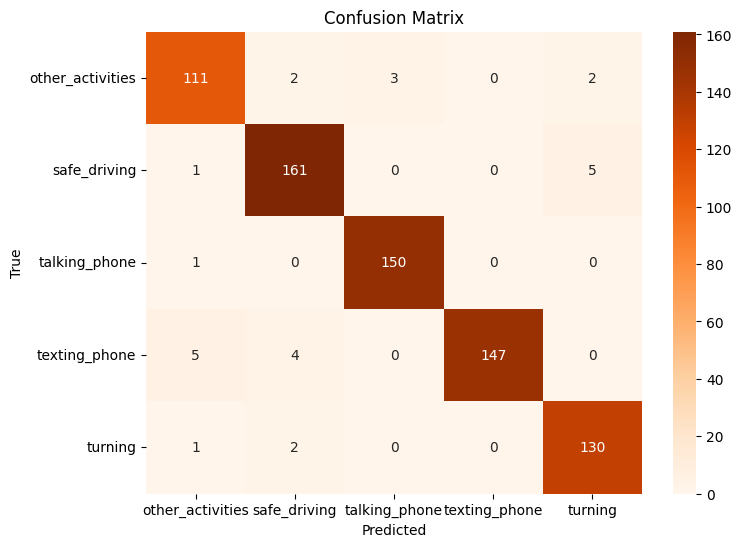

In [17]:
# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [18]:
# --- In kiến trúc mô hình ---
print("\nKiến trúc mô hình:")
print(model_loaded)


Kiến trúc mô hình:
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2

In [19]:
# --- Tổng số tham số ---
total_params = sum(p.numel() for p in model_loaded.parameters())
trainable_params = sum(p.numel() for p in model_loaded.parameters() if p.requires_grad)
print(f"\nTổng số tham số: {total_params:,}")
print(f"Tham số huấn luyện được: {trainable_params:,}")


Tổng số tham số: 4,013,953
Tham số huấn luyện được: 4,013,953


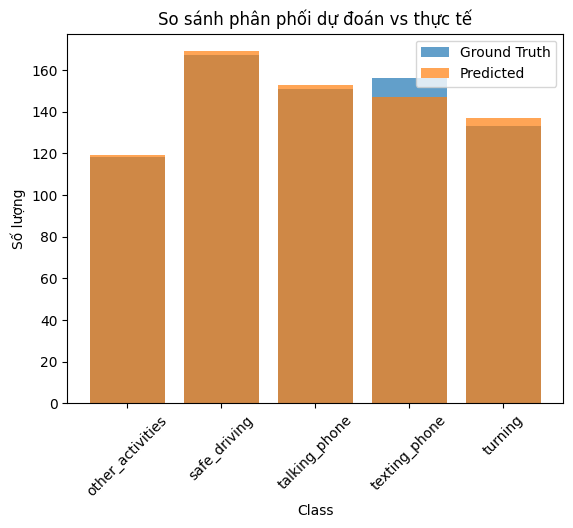

In [20]:
# --- So sánh phân phối dự đoán vs thực tế ---
pred_counts = collections.Counter(all_preds)
label_counts = collections.Counter(all_labels)

plt.bar(class_names, [label_counts[i] for i in range(len(class_names))], alpha=0.7, label="Ground Truth")
plt.bar(class_names, [pred_counts[i] for i in range(len(class_names))], alpha=0.7, label="Predicted")
plt.title("So sánh phân phối dự đoán vs thực tế")
plt.xlabel("Class")
plt.ylabel("Số lượng")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [21]:
# --- Thời gian dự đoán trung bình ---
def measure_inference_time(model, dataloader, n_batches=5):
    model.eval()
    total_time = 0.0
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            if i >= n_batches:
                break
            inputs = inputs.to(device)
            start = time.time()
            _ = model(inputs)
            end = time.time()
            total_time += (end - start)
    avg_time = total_time / n_batches
    print(f"\nThời gian dự đoán trung bình (batch size={inputs.size(0)}): {avg_time:.4f} giây")
    return avg_time

measure_inference_time(model_loaded, val_loader)


Thời gian dự đoán trung bình (batch size=32): 0.0846 giây


0.08459262847900391

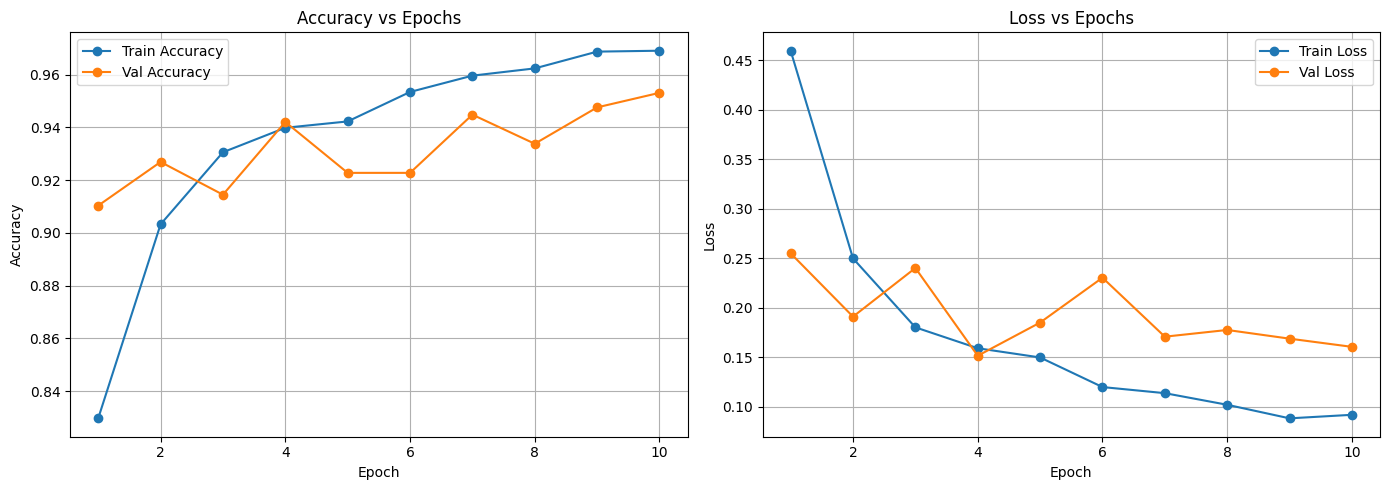

In [22]:


# --- Accuracy và Loss theo Epochs ---
epochs = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Val Accuracy', marker='o')
plt.title("Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
# --- MAP (Mean Average Precision) ---
map_score = precision_score(all_labels, all_preds, average='macro')
print(f"\nMean Average Precision (MAP - macro): {map_score:.4f}")


Mean Average Precision (MAP - macro): 0.9629


In [24]:
train_losses

[0.45957158465200243,
 0.24985872286919733,
 0.18025769767051997,
 0.15915146027439586,
 0.1498512007737179,
 0.11997114712813196,
 0.11381138211638273,
 0.10208101470799949,
 0.08838614708195663,
 0.09195503272458048]

In [25]:
val_losses

[0.25501326961763976,
 0.19106547238497898,
 0.24017018323956893,
 0.15157774670370694,
 0.18510211652722852,
 0.23038699427555348,
 0.17083285509512341,
 0.17761409509798576,
 0.16884001337345048,
 0.16057213398403136]

In [26]:
train_accuracies

[0.8296958240247466,
 0.9032479807527067,
 0.9305722632754769,
 0.9398522082832103,
 0.9422581199518818,
 0.9534284241278571,
 0.9596150541330126,
 0.9623646674686372,
 0.9687231483072694,
 0.9690668499742224]

In [27]:
val_accuracies

[0.9103448275862068,
 0.9268965517241379,
 0.9144827586206896,
 0.9420689655172413,
 0.9227586206896551,
 0.9227586206896551,
 0.9448275862068964,
 0.9337931034482758,
 0.9475862068965516,
 0.953103448275862]